In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
import sys
sys.path.append('..')
from dataset.sentinel import *
from models.lstm_ae import *
import torch
import random
from pathlib import Path
from config import *
from utils import *
from lstm_utils import *

import numpy as np
import platform
import json

architecture='lstm_ae'

In [4]:
exp_dict = exp_name_folders(path =esa_exploration, architecture='lstm_ae')
for k in exp_dict.keys():
    print('num selection:{} - exp name:{}'.format(k, exp_dict[k]))

num selection:0 - exp name:4_wheel_system_extended_params_sl_16
num selection:1 - exp name:4_wheel_system_extended_params_sl_100
num selection:2 - exp name:4_wheel_system_lstm_ae_sl_30_run1
num selection:3 - exp name:third_wheel_extended_params_sl_100
num selection:4 - exp name:third_wheel_lstm_extended_params_sl_30_run_1


In [17]:
select_exp = '4'
added_path = exp_dict[select_exp]
model_results_path = esa_exploration + '{}/{}'.format(architecture, added_path)
print('selected experiment:', added_path)

selected experiment: third_wheel_lstm_extended_params_sl_30_run_1


In [18]:
files = os.listdir(model_results_path)
model_list, summary = find_models(files, model_results_path)

summary path: /srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/third_wheel_lstm_extended_params_sl_30_run_1/summary.csv


In [19]:
summary.reset_index().head(10)

,index,Unnamed: 0,name,parameters_number,train_loss,val_loss
0,49,4,"trainLSTMAE_f47c9_00039_39_batch_size=100,embe...",239124,0.002192,0.001923
1,48,38,"trainLSTMAE_f47c9_00041_41_batch_size=100,embe...",239124,0.002192,0.001923
2,47,28,"trainLSTMAE_f47c9_00035_35_batch_size=100,embe...",235104,0.002357,0.002065
3,46,48,"trainLSTMAE_f47c9_00047_47_batch_size=1000,emb...",235104,0.003359,0.002791
4,45,37,"trainLSTMAE_f47c9_00037_37_batch_size=500,embe...",156500,0.004595,0.003688
5,44,36,"trainLSTMAE_f47c9_00046_46_batch_size=100,embe...",150060,0.005463,0.004510
6,43,22,"trainLSTMAE_f47c9_00048_48_batch_size=500,embe...",150060,0.005585,0.004624
7,42,6,"trainLSTMAE_f47c9_00017_17_batch_size=500,embe...",243936,0.010910,0.010951
8,41,1,"trainLSTMAE_f47c9_00003_3_batch_size=500,embed...",160352,0.014152,0.015251
9,40,23,"trainLSTMAE_f47c9_00045_45_batch_size=1000,emb...",150060,0.016978,0.017164


In [20]:
rank = 0
model_name_path = select_by_rank(rank, model_results_path, summary)
model_name = summary.name.iloc[rank]
f = open(os.path.join(model_results_path, '/'.join(model_name_path.split('/')[:-2]), 'params.json'))
print('hyper-parameters')
print(json.load(f))

hyper-parameters
{'batch_size': 100, 'embedding_dim': 40, 'epochs': 200, 'latent_dim': 80, 'lr': 0.0009, 'lr_patience': 5, 'n_layers_cell_1': 2, 'n_layers_cell_2': 2, 'seq_in_length': 30}


In [21]:
checkpoint  = torch.load(os.path.join(model_results_path, model_name_path))
params_conf = checkpoint['param_conf']
cfg = checkpoint['cfg']

In [22]:
if platform.node()=='leonard':
    device='cpu'
else:
    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda:0" if use_cuda else "cpu")

In [23]:
dataset_name = os.path.join(data_path.strip('..'), "all_2016-2018_clean_std_4s.pkl")
transform = None
df_train, df_test, train_iter, test_iter = \
read_dataset(dataset_name=dataset_name, scaled=params_conf['scaled'], cols=checkpoint['cfg']['dataset']['columns'],
columns_subset=cfg['dataset']['columns_subset'], dataset_subset=cfg['dataset']['dataset_subset']
, sequence_length=params_conf['sequence_length'],out_window=params_conf['sequence_length'], 
train_val_split=cfg['dataset']['train_val_split'], batch_size=params_conf['batch_size'], transform=transform)    

In [24]:
num_batch=10
print('time horizon {}'.format(num_batch*params_conf['sequence_length']))
x, shift = unrolling_batches(num_batch, test_iter, sequence_length=params_conf['sequence_length']
                             , cols=cfg['dataset']['columns'])

time horizon 300
random shift 19429


In [25]:
try:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
            n_features=params_conf['n_features'], output_size=params_conf['output_size'],
            embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                    n_layers_1=params_conf['n_layers_1'], n_layers_2=params_conf['n_layers_2'])
except:
    model = LSTM_AE(seq_in=params_conf['sequence_length'],seq_out=params_conf['out_window'],
        n_features=params_conf['n_features'], output_size=params_conf['output_size'],
        embedding_dim=params_conf['embedding_dim'], latent_dim=params_conf['latent_dim'],
                n_layers_1=params_conf['n_layers'], n_layers_2=params_conf['n_layers'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device).eval()
print('parameters number', count_parameters(model))

LSTM_AE(
  (encoder): Encoder(
    (LSTMenc): LSTM(4, 80, num_layers=2, batch_first=True)
    (LSTM1): LSTM(80, 40, num_layers=2, batch_first=True)
    (enc): Linear(in_features=40, out_features=80, bias=True)
  )
  (decoder): Decoder(
    (LSTMdec): LSTM(80, 40, num_layers=2, batch_first=True)
    (LSTM1): LSTM(40, 80, num_layers=2, batch_first=True)
    (fc): Linear(in_features=80, out_features=4, bias=True)
  )
)
parameters number 239124


In [26]:
x, enc, yo = model(x.to(device))

In [27]:
path = './figure_results/{}/{}/'.format(model_results_path, shift)
par_nums=count_parameters(model)
print(path)
save = False

./figure_results//srv/penny/FIORIRE/time_series_anomaly_detection/model_results/esa_exploration/lstm_ae/third_wheel_lstm_extended_params_sl_30_run_1/19429/


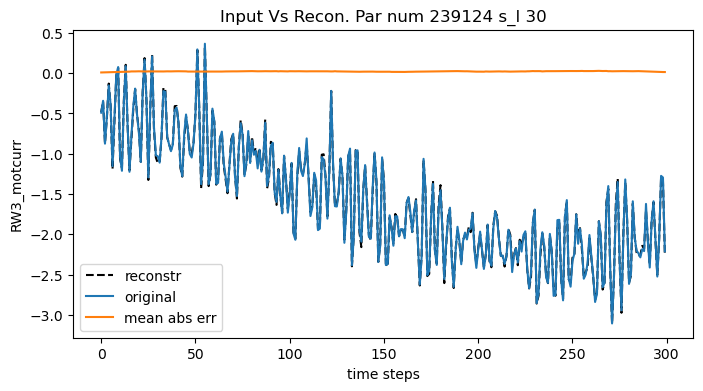

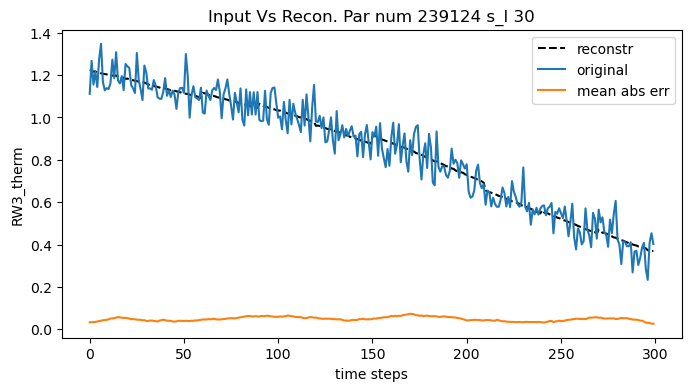

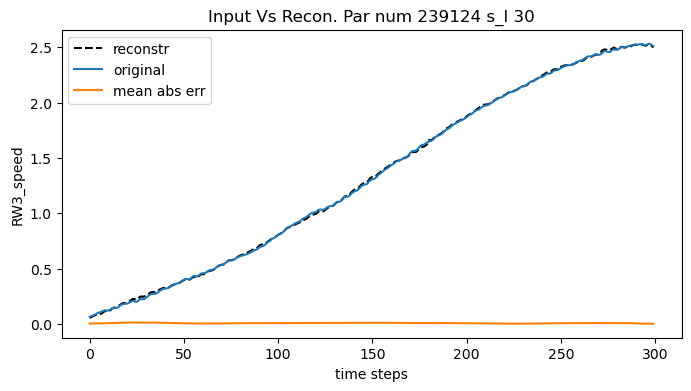

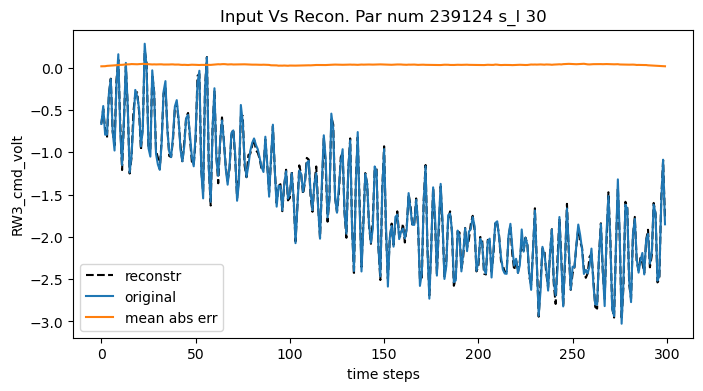

In [29]:
show_results(x,yo,checkpoint['cfg']['dataset']['columns'],
    model_name,params_conf,
    par_nums,shift,num_batch,
    architecture='lstm_ae',
    save=False)